## Revisiting the nonlinear fitting example from a Bayesian viewpoint

For simplicity, we'll start with a simplified model that has only 2 parameters instead of 5. The original model was

$$
y(x) = b_1 \exp\left(-b_2 x\right) + \frac{b_3}{b_5\sqrt{2\pi}} \exp\left(-\tfrac12\frac{(x-b_4)^2}{b_5^2}\right)
$$

(the sum of a decaying exponential background, and a Gaussian peak). We can assume, for example, that we already know the values of parameters $b_1=1.12,b_4=3.26,b_5=1.48$, such that our simplified model reads:

$$
y(x) = 1.12 \exp\left(-b_2 x\right) + \frac{b_3}{1.48\sqrt{2\pi}} \exp\left(-\tfrac12\frac{(x-3.26)^2}{1.48^2}\right)
$$

We first load some standard packages, including `scipy.optimize` and `lmfit` for the nonlinear optimisation.


In [49]:
import numpy as np
import os, sys
from numpy import exp, pi, sqrt

from numpy import linspace

import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statistics import stdev
import scipy.optimize as optimization
from lmfit import minimize, Parameters, report_fit
from scipy.optimize import leastsq
import emcee #conda install -c conda-forge emcee

Define our simplified model, 

In [18]:

# def model_peak(x, b1, b2, b3, b4, b5):
#     return b1*exp(-b2*x) + b3/(sqrt(2*np.pi)*b5)*exp(-0.5*(x-b4)**2 / b5**2)


def model_peak(x, b2, b3):
    return 1.12*exp(-b2*x) + b3/(sqrt(2*np.pi)*1.48)*exp(-0.5*(x-3.26)**2 / 1.48**2)


### Defining the Likelihood


In the context of Bayesian inference, a _"nonlinear fit"_ is understood as the most probable set of parameters for the posterior distribution. From Bayes' theorem, the posterior distribution is obtained as:

$$
P(M|D,I) = \frac{P(D|M,I)P(M,I)}{P(D,I)}
$$
where $M$ stands for _Model parameters_, $D$ for _Data_, $I$ is general information about the problem (such as our choice of a theoretical model – one could imagine an independent hypothesis). The different terms in this formula are known as:

- $P(M|D,I)$: **Posterior** distribution of the model parameters, given our prior knowledge and the data
- $P(M,I)$: **Prior** distribution of the model parameters, before taking the data into account
- $\mathcal{L}\equiv P(D|M,I)$: **Likelihood** probability of the observed data, given some parameters of the chosen model
- $P(D,I)$: **Evidence** normalisation factor to ensure that the posterior distribution is correctly normalised (can be used to compare models)

In our case we will ignore the normalisation factor and simply calculate $P(M|D,I) \propto P(D|M,I)P(M,I)$.

When we have little information on the model parameters, the prior distribution may be taken as a constant over the range of values we consider realistic. In such a case, finding the maximum of the posterior distribution is equivalent to maximising the likelihood – this leads to the Maximum Likelihood "principle" used in nonlinear fitting, here justified as a special case of the Bayesian approach.

A further simplification is often applied in practice, which leads to the minimisation of the sum of squares: in the case of Gaussian, independent noise, $\mathcal{L}=\Pr(D|M,I) = (2\pi)^{-N/2} \exp \left [-1/2 \sum_{i=1}^{N}\left(\frac{y_i - \text{model}(x_i,M)}{\sigma_i}\right)^2\right ] \prod_i^N \sigma_i^{-1}$ where $N$ is the number of datapoints $(x_i,y_i)$ and $\sigma_i$ is the error on each individual datapoint.  For computational reasons, it is advantageous to maximise the logarithm of the likelihood (in fact, minimise the negative of the log-likelihood $-\log\mathcal{L}$), rather than the likelihood itself, and we end up with the common sum of squares objective function:

$$
\chi^2 = \sum_{i=1}^{N}\left(\frac{y_i - \text{model}(x_i,M)}{\sigma_i}\right)^2
$$

which is to be minimised. Intuitively, we wish to find the model parameters that minimise the discrepancy between the model's predicted values, and the observations $y_i$.

We follow the formula above to implement the log-likelihood (note: $\theta$ is a common convention for the vector of model parameters, in our case $[b_2,b_3]$).

In [19]:

def log_likelihood(theta, x, y, yerr):
    b2, b3 = theta
    model = model_peak(x, b2, b3)
    logLhood0=np.size(y)/2*np.log(2*np.pi)+np.sum(np.log(yerr))
    chi2=np.sum(((y - model)/yerr)**2)
    return -chi2/2-logLhood0


### Maximising the log-likelihood

We first load the data and check them with a plot

In [20]:
data = pd.read_csv("exppeak.txt", header=0, delim_whitespace=True)
data


,x,y,sigma
0,0.000,1.17747,0.0357
1,0.526,0.64436,0.0272
2,1.053,0.53100,0.0353
3,1.579,0.52761,0.0323
4,2.105,0.64534,0.0313
5,2.632,0.80235,0.0419
6,3.158,0.82748,0.0334
7,3.684,0.74864,0.0265
8,4.211,0.64265,0.0364
9,4.737,0.48122,0.0375


Next we find the optimum model parameters by minimising the (negative) log-likelihood, and confirm graphically that the fit is reasonable:

Maximum likelihood estimates:
b2 = 1.476
b3 = 2.989
Covariance matrix:
[[0.00639495 0.00200981]
 [0.00200981 0.00357813]]
Uncertainties:
[0.07996843 0.05981751]


Text(0, 0.5, 'y')

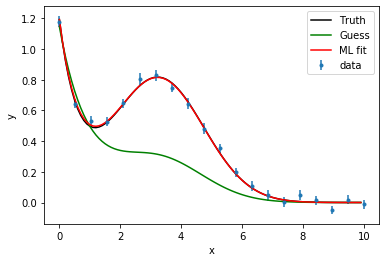

In [29]:
nll = lambda *args: -log_likelihood(*args) # wrapper function to expand a vector of parameters as arguments
initial = [ 1, 1]
soln = optimization.minimize(nll, initial, args=(data.x, data.y, data.sigma))
b2, b3 = soln.x
err = np.sqrt(np.diag(soln.hess_inv))
print("Maximum likelihood estimates:")
print("b2 = {0:.3f}".format(b2))
print("b3 = {0:.3f}".format(b3))
print("Covariance matrix:")
print(format(soln.hess_inv))
print("Uncertainties:")
print(format(err))

xx = np.arange(0,10,0.1)
p_truth = [1.52, 3]
truth = model_peak(xx, *p_truth)
guess = model_peak(xx, *initial)
fit_ML = model_peak(xx, b2, b3)
pyplot.errorbar(data.x, data.y, yerr=data.sigma, fmt='.', label='data')
pyplot.plot(xx, truth, 'k-', label='Truth')
pyplot.plot(xx, guess, 'g', label='Guess')
pyplot.plot(xx, fit_ML, 'r', label='ML fit')
pyplot.legend(loc='best')
pyplot.xlabel("x")
pyplot.ylabel("y")

Going back to the more general Bayesian inference, we may wish to explore the shape of the posterior distribution of the model parameters. This provides much more information than just obtaining the _"best"_ set of model parameters (assuming the minimiser has even found them): we'll learn for example if there are multiple minima that might provide different possibilities for "best-fit" parameters, but also, crucially, how strongly-constrained are the fitted parameters.

For this example, we define a simple prior distribution for the parameters, which is constant over a range (it should be normalised to unity, but we are already ignoring a normalising factor in the posterior distribution, which is not important as we are only interested in the shape of the distribution). The logarithm of such priors may be implemented as:

In [22]:
def log_prior(theta):
    b2, b3 = theta
    if  0.1 < b2 < 5.0 and 0.1 < b3 < 5.0 :
        return 0.0
    return -np.inf


In turn, the posterior distribution is just the product of the prior and the likelihood, which becomes a sum for the log-posterior,

In [23]:

def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Since our problem has only two free parameters, we can evaluate the posterior distribution on a fine grid of parameters to explore its shape. 

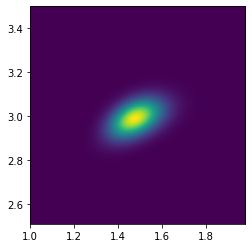

In [39]:
def objective_fun(x, y):
    return np.exp(log_posterior([x,y], data.x, data.y, data.sigma))


dx, dy = 0.02, 0.015

x = np.arange(1, 2.0, dx)
y = np.arange(3.5, 2.5, -dy)
X, Y = np.meshgrid(x, y)

vobjective_fun = np.vectorize(objective_fun)

Z = vobjective_fun(X, Y)

fig = plt.figure(frameon=False)
im = plt.imshow(Z, cmap=plt.cm.viridis,interpolation='bilinear', extent=[x.min(),x.max(),y.min(),y.max()])

plt.show()

This 2-dimensional map of the objective function reveals a correlation between the fitted parameters, which affects their uncertainty. To summarise the posterior distribution of each parameter independently, we can _marginalise_ by integrating over the other dimension:

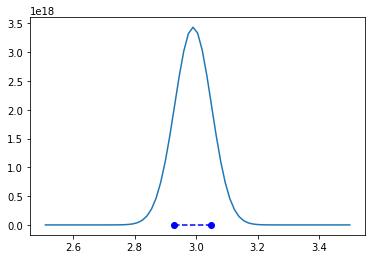

In [53]:
s3 = Z.sum(axis=1)*dy
plt.plot(y,s3)

plt.plot([b3 - err[1], b3 + err[1]], [0,0], 'bo', linestyle="--")

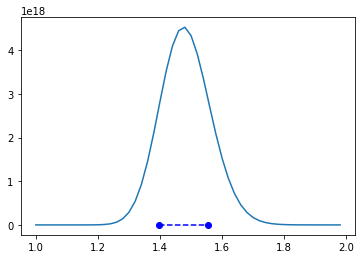

In [54]:
s2 = Z.sum(axis=0)*dx
plt.plot(x,s2)
plt.plot([b2 - err[0], b2 + err[0]], [0,0], 'bo', linestyle="--")

(note again that we are only interested in the shape of the distribution; the y scale is not correctly normalised here)

We've superimposed as horizontal segments the uncertainty estimated from the covariance matrix returned by the minimizer, which corresponds more or less to 68% of the probability (assuming it is roughly a gaussian).

When parameters have more than a couple of parameters, it rapidly becomes impossible to compute the likelihood over a grid of parameters (for example, with just 50 grid points per dimension, we'd need $50^d$ function evaluations in $d$ dimensions, that is $50 (d=1), 2500 (d=2), 125000 (d=3),  6250000 (d=4), 312500000 (d=5)\dots$.

Instead, we may use a powerful class of algorithms known as Markov Chain Monte Carlo methods to _sample_ the posterior density with much fewer function evaluations, but still providing a good representation of its shape. (Of course, some caveats apply). This is the topic of the next workbook.